In [23]:
!sudo apt install graphviz graphviz-dev
!pip install pygraphviz pm4py

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from joblib import Parallel, delayed
from scipy.cluster.hierarchy import linkage, fcluster
from dunn import *
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.objects.conversion.dfg import converter as dfg_mining
import copy
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pickle
from math import pi
import os
import networkx as nx
import pygraphviz as pgv
from matplotlib import rc
from urllib.request import urlretrieve
import gzip
import shutil
from IPython.display import Image
from plotfunctions import *


rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=False)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def gunzip(file):    
    with gzip.open(file + '.gz', 'rb') as f_in:
        with open(file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

## Load Data

### Downlaod and Extract Logs

In [3]:
urlretrieve("https://data.4tu.nl/ndownloader/files/24060575", "BPI_2014.csv")

urlretrieve("https://data.4tu.nl/ndownloader/files/24027287", "BPI_2012.xes.gz")
gunzip("BPI_2012.xes")

urlretrieve("https://data.4tu.nl/ndownloader/files/24063818", "BPI2015_1.xes")
urlretrieve("https://data.4tu.nl/ndownloader/files/24044639", "BPI2015_2.xes")
urlretrieve("https://data.4tu.nl/ndownloader/files/24076154", "BPI2015_3.xes")
urlretrieve("https://data.4tu.nl/ndownloader/files/24045332", "BPI2015_4.xes")
urlretrieve("https://data.4tu.nl/ndownloader/files/24069341", "BPI2015_5.xes")

urlretrieve("https://data.4tu.nl/ndownloader/files/24044117", "BPI_2017.xes.gz")
gunzip("BPI_2017.xes")

### Import Logs

In [4]:
dfs = []

In [5]:
# BPI Challenge 2014 is only available as CSV. Column Names have to be standardized to work with the rest of the code. Incomplete Traces were removed
df = pd.read_csv("BPI_2014.csv", sep=";")
df = df.loc[df["Incident ID"].isin(df.loc[df["IncidentActivity_Type"] == "Open", "Incident ID"].tolist()) & df["Incident ID"].isin(df.loc[df["IncidentActivity_Type"] == "Closed", "Incident ID"].tolist())]
df.columns = ["case:concept:name", "time:timestamp", "actnumber", "concept:name", "org:resource", "kmnumber", "intid"]
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"], format="%d-%m-%Y %H:%M:%S")
df = df.sort_values(["case:concept:name", "time:timestamp"])
dfs.append(df)

In [6]:
# BPI CHallenge 2012
log = xes_importer.apply('BPI_2012.xes')
df = converter.apply(log, variant=converter.Variants.TO_DATA_FRAME)
dfs.append(df)

In [7]:
# BPI CHallenge 2017
log = xes_importer.apply('BPI_2017.xes')
df = converter.apply(log, variant=converter.Variants.TO_DATA_FRAME)
dfs.append(df)

In [8]:
# BPI Challenge 2015 consists of 5 logs. We append the logs to get one large log
df = pd.DataFrame()
for i in range(1,6):
    log = xes_importer.apply('BPI2015_'+ str(i) +'.xes')
    dd = converter.apply(log, variant=converter.Variants.TO_DATA_FRAME)
    df = df.append(dd)
dfs.append(df)

## Ngram Vectorizing

In [29]:
ngramlist = []
tracelist = []
for df in dfs:
    traces = df.groupby("case:concept:name")["concept:name"].agg(lambda col: ",".join(col.tolist())).reset_index()
    tracelist.append(traces)
    vectorizer = CountVectorizer(ngram_range=(3, 3), token_pattern='(?u)[\w \(\)]+', analyzer='word')
    ngrams = vectorizer.fit_transform(traces["concept:name"].tolist())
    ngramlist.append(ngrams)

## Clustering

In [30]:
clusterlist = []
for ngrams in ngramlist:    
    clusters  = hierarchy.ward(ngrams.toarray())
    clusterlist.append(clusters)

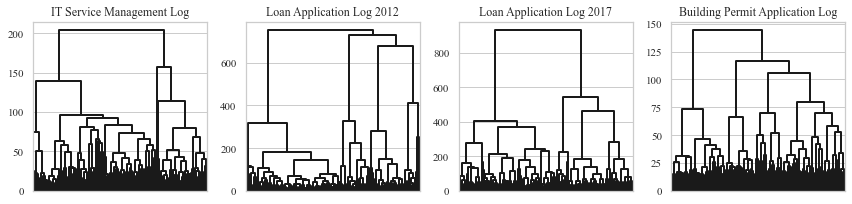

In [31]:
fig, axs = plt.subplots(1,4, figsize=(12,3))
for clusters, ax in zip(clusterlist, axs):
    hierarchy.dendrogram(clusters, no_labels=True, ax=ax, truncate_mode="level", p=15, color_threshold=0, above_threshold_color='k')
    
axs[0].set_title("IT Service Management Log", fontname="Times New Roman")
axs[1].set_title("Loan Application Log 2012", fontname="Times New Roman")
axs[2].set_title("Loan Application Log 2017", fontname="Times New Roman")
axs[3].set_title("Building Permit Application Log", fontname="Times New Roman")
    
plt.tight_layout()
plt.savefig("Figure_7.svg")

## Determine Number of Clusters <span style="color:red">(!Long Runtime!)</span>

This section can be skipped, the number of clusters is hard-coded in the next section

### Elbow Criterion

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(12,3))
for clusters, ax in zip(clusterlist, axs):
    last = clusters[-1200000:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    ax.plot(idxs, last_rev)

### Silhouette Score

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(12,3))
for clusters, ax in zip(clusterlist, axs):
    silhouette = Parallel(n_jobs=-1)(delayed(silhouette_score)(ngrams.toarray(), fcluster(clusters, i, criterion='maxclust')) for i in range(2,100))
    print(np.argmax(silhouette)+2)
    plt.plot(silhouette)

### Davies-Bouldin Index

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(12,3))
for clusters, ax in zip(clusterlist, axs):
    db_index = Parallel(n_jobs=-1)(delayed(davies_bouldin_score)(ngrams.toarray(), fcluster(clusters, i, criterion='maxclust')) for i in range(2,100))
    print(np.argmin(db_index)+2)
    ax.plot(db_index)

### Calinski-Harabasz Index

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(12,3))
for clusters, ax in zip(clusterlist, axs):
    ch_score = Parallel(n_jobs=-1)(delayed(calinski_harabasz_score)(ngrams.toarray(), fcluster(clusters, i, criterion='maxclust')) for i in range(2,100))
    plt.plot(ch_score)

## Dataset Description

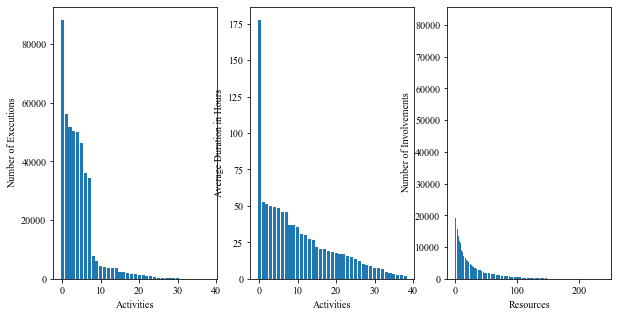

In [9]:
df = dfs[0] # IT Service Management Log

act = df.groupby("concept:name").count()["case:concept:name"].tolist()
df.sort_values(["case:concept:name", "time:timestamp"])
df["time:next"] = df["time:timestamp"].tolist()[1:] + [pd.to_datetime("2000-01-01")]
df["case:next"] = df["case:concept:name"].tolist()[1:] + [0]
df["time"] =  (pd.to_datetime(df["time:next"], utc=True) - pd.to_datetime(df["time:timestamp"], utc=True)).apply(lambda x: x.total_seconds())
actdur = (df.loc[(df["time"] > 0)].groupby("concept:name").mean()["time"] / 3600).tolist()
resources = df.groupby("org:resource").count()["concept:name"].tolist()

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].bar([i for i,j in enumerate(act)], sorted(act, reverse=True))
axs[1].bar([i for i,j in enumerate(actdur)], sorted(actdur, reverse=True))
axs[2].bar([i for i,j in enumerate(resources)], sorted(resources, reverse=True))


axs[0].set_xlabel("Activities", fontname="Times New Roman")
axs[1].set_xlabel("Activities", fontname="Times New Roman")
axs[2].set_xlabel("Resources", fontname="Times New Roman")

axs[0].set_ylabel("Number of Executions", fontname="Times New Roman")
axs[1].set_ylabel("Average Duration in Hours", fontname="Times New Roman")
axs[2].set_ylabel("Number of Involvements", fontname="Times New Roman")

fig.tight_layout()
plt.savefig("figure_4.svg")

30.91416306805164
45687
432.6632563611111
148404


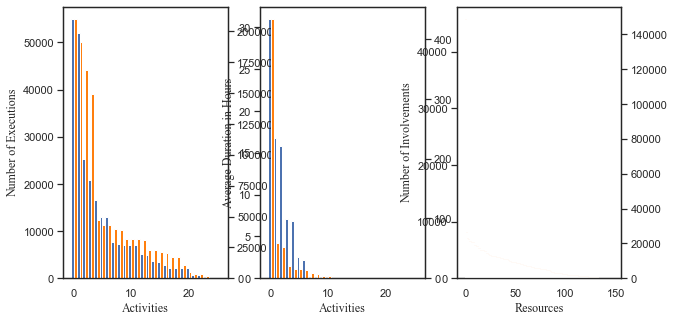

In [49]:
df = dfs[1] # Loan Application Log 2012

act = df.groupby("concept:name").count()["case:concept:name"].tolist()
df.sort_values(["case:concept:name", "time:timestamp"])
df["time:next"] = df["time:timestamp"].tolist()[1:] + [pd.to_datetime("2000-01-01")]
df["case:next"] = df["case:concept:name"].tolist()[1:] + [0]
df["time"] =  (pd.to_datetime(df["time:next"], utc=True) - pd.to_datetime(df["time:timestamp"], utc=True)).apply(lambda x: x.total_seconds())
actdur = (df.loc[df["time"] > 0].groupby("concept:name").mean()["time"] / 3600).tolist()
resources = df.groupby("org:resource").count()["concept:name"].tolist()

print(max(actdur))
print(max(resources))

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].bar([i-.25 for i,j in enumerate(act)], sorted(act, reverse=True), width=.5)
axs[1].bar([i-.25 for i,j in enumerate(actdur)], sorted(actdur, reverse=True), width=.5)
axs[2].bar([i-.25 for i,j in enumerate(resources)], sorted(resources, reverse=True), width=.5)

df = dfs[2] # Loan Application Log 2017

act = df.groupby("concept:name").count()["case:concept:name"].tolist()
df.sort_values(["case:concept:name", "time:timestamp"])
df["time:next"] = df["time:timestamp"].tolist()[1:] + [pd.to_datetime("2000-01-01")]
df["case:next"] = df["case:concept:name"].tolist()[1:] + [0]
df["time"] =  (pd.to_datetime(df["time:next"], utc=True) - pd.to_datetime(df["time:timestamp"], utc=True)).apply(lambda x: x.total_seconds())
actdur = (df.loc[(df["time"] > 0)].groupby("concept:name").mean()["time"] / 3600).tolist()
resources = df.groupby("org:resource").count()["concept:name"].tolist()

print(max(actdur))
print(max(resources))

axs[0].twinx().bar([i+.25 for i,j in enumerate(act)], sorted(act, reverse=True), width=.5, color="tab:orange")
axs[1].twinx().bar([i+.25 for i,j in enumerate(actdur)], sorted(actdur, reverse=True), width=.5, color="tab:orange")
axs[2].twinx().bar([i+.25 for i,j in enumerate(resources)], sorted(resources, reverse=True), width=.5, color="tab:orange")

axs[0].set_xlabel("Activities", fontname="Times New Roman")
axs[1].set_xlabel("Activities", fontname="Times New Roman")
axs[2].set_xlabel("Resources", fontname="Times New Roman")

axs[0].set_ylabel("Number of Executions", fontname="Times New Roman")
axs[1].set_ylabel("Average Duration in Hours", fontname="Times New Roman")
axs[2].set_ylabel("Number of Involvements", fontname="Times New Roman")

#fig.tight_layout()
plt.savefig("figure_5.svg")

5644
5806.293055555556
15748


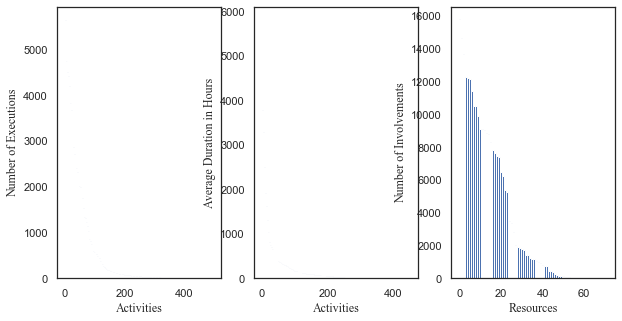

In [48]:
df = dfs[3] # Building Permit Log

act = df.groupby("concept:name").count()["case:concept:name"].tolist()
df.sort_values(["case:concept:name", "time:timestamp"])
df["time:next"] = df["time:timestamp"].tolist()[1:] + [pd.to_datetime("2000-01-01")]
df["case:next"] = df["case:concept:name"].tolist()[1:] + [0]
df["time"] =  (pd.to_datetime(df["time:next"], utc=True) - pd.to_datetime(df["time:timestamp"], utc=True)).apply(lambda x: x.total_seconds())
actdur = (df.loc[(df["time"] > 0)].groupby("concept:name").mean()["time"] / 3600).tolist()
resources = df.groupby("org:resource").count()["concept:name"].tolist()


print(max(act))
print(max(actdur))
print(max(resources))

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].bar([i for i,j in enumerate(act)], sorted(act, reverse=True))
axs[1].bar([i for i,j in enumerate(actdur)], sorted(actdur, reverse=True))
axs[2].bar([i for i,j in enumerate(resources)], sorted(resources, reverse=True))


axs[0].set_xlabel("Activities", fontname="Times New Roman")
axs[1].set_xlabel("Activities", fontname="Times New Roman")
axs[2].set_xlabel("Resources", fontname="Times New Roman")

axs[0].set_ylabel("Number of Executions", fontname="Times New Roman")
axs[1].set_ylabel("Average Duration in Hours", fontname="Times New Roman")
axs[2].set_ylabel("Number of Involvements", fontname="Times New Roman")

#fig.tight_layout()
plt.savefig("figure_6.svg")

## Calculate Scores

In [35]:
scorelist = []
nclusterlist = [150, 200, 200, 300]

for df, traces, nclusters, clusters in zip(dfs, tracelist, nclusterlist, clusterlist):
    df.sort_values(["case:concept:name", "time:timestamp"])
    df["time:next"] = df["time:timestamp"].tolist()[1:] + [pd.to_datetime("2000-01-01")]
    df["case:next"] = df["case:concept:name"].tolist()[1:] + [0]
    df["time"] =  (pd.to_datetime(df["time:next"], utc=True) - pd.to_datetime(df["time:timestamp"], utc=True)).apply(lambda x: x.total_seconds())

    labels = fcluster(clusters, nclusters, criterion='maxclust')
    traces["cluster"] = labels

    clusterdict = {}
    for i in range(1,nclusters+1):
        clusterdict[i] = traces.loc[traces["cluster"] == i]["case:concept:name"].tolist()

    # execution Frequency
    scores = []
    for i in range(1,nclusters+1):
        cases = clusterdict[i]
        temp = df.loc[df["case:concept:name"].isin(cases)]
        score = temp["case:concept:name"].nunique()
        scores.append(score)
    ef = scores

    # stakeholder scores
    stakeholer_scores = df.groupby("org:resource").count()["concept:name"].to_dict()
    stakeholer_scores = {s:(1 / stakeholer_scores[s]) for s in stakeholer_scores}
    df["sscore"] = df["org:resource"].replace(stakeholer_scores)
    scores = []
    for i in range(1,nclusters+1):
        cases = clusterdict[i]
        temp = df.loc[df["case:concept:name"].isin(cases)]
        score = np.sum(temp.groupby(["case:concept:name"]).sum()["sscore"] / temp.shape[0])
        scores.append(score)
    ss = scores

    #customer contacts
    scores = []
    for i in range(1,nclusters+1):
        cases = clusterdict[i]
        temp = df.loc[df["case:concept:name"].isin(cases)]
        if nclusters == 300:
            score = temp.loc[(temp["activityNameEN"].str.contains("send"))].shape[0] / temp.shape[0]
        else:
            score = temp.loc[(temp["concept:name"].str.contains("Sent")) | (temp["concept:name"].str.contains("SENT")) | (temp["concept:name"].str.contains("customer"))].shape[0] / temp.shape[0]
        #

        scores.append(score)
    cc = scores

    # activity variance scores

    scores = []
    for i in range(1,nclusters+1):
        cases = clusterdict[i]
        temp = df.loc[df["case:concept:name"].isin(cases) & (df["case:next"] == df["case:concept:name"]) & (df["time"] > 1)]
        score = temp["time"].var()
        scores.append(score)
    av = scores

    # process variance scores
    scores = []
    for i in range(1,nclusters+1):
        cases = clusterdict[i]
        temp = df.loc[df["case:concept:name"].isin(cases)]
        score = (pd.to_datetime(temp.groupby("case:concept:name").last()["time:timestamp"], utc=True) - pd.to_datetime(temp.groupby("case:concept:name").first()["time:timestamp"], utc=True)).apply(lambda x: x.total_seconds()).var()
        scores.append(score)
    pv = [s if str(s) != "nan" else 0 for s in scores ]

    # redundancies 

    scores = []
    for i in range(1,nclusters+1):
        cases = clusterdict[i]
        temp = traces.loc[traces["case:concept:name"].isin(cases)]["concept:name"].tolist()

        ngram_vectorizer = CountVectorizer(input = temp, ngram_range=(2,2), tokenizer=lambda x: x.split(','))
        counts = ngram_vectorizer.fit_transform(temp)
        #names = ngram_vectorizer.get_feature_names()

        counts[counts == 1] = 0
        trlen = [len(t.split(",")) for t in temp]
        scores.append(np.sum(counts) / np.sum(trlen))

    rs = scores

    # shared activity contexts
    ngram_vectorizer = CountVectorizer(input = traces["concept:name"].tolist(), ngram_range=(3,3), tokenizer=lambda x: x.split(','))
    counts = ngram_vectorizer.fit_transform(traces["concept:name"].tolist())
    names = ngram_vectorizer.get_feature_names()
    activities = df["concept:name"].unique().tolist()
    contexts = []

    actcount = {}
    for activity in activities:
        for name in names:
            if " " + str(activity).lower() + " " in name:
                if activity in actcount:
                    actcount[activity] += 1
                else:
                    actcount[activity] = 1

    actcount["A_Create Application"] = 0
    actcount["A_SUBMITTED"] = 0
    actcount["01_BB_680"] = 0
    actcount["14_VRIJ_060_2"] = 0
    actcount["01_BB_601"] = 0
    actcount["01_BB_650_2"] = 0

    df["actscores"] = df["concept:name"].replace(actcount)

    scores = []
    for i in range(1,nclusters+1):
        cases = clusterdict[i]
        temp = df.loc[df["case:concept:name"].isin(cases)]
        #print(temp["actscores"])
        score = (temp["actscores"].sum() / temp.shape[0]) **-1 
        scores.append(score)
    sas = scores

    # stakeholder count scores
    scores = []
    for i in range(1,nclusters+1):
        cases = clusterdict[i]
        temp = df.loc[df["case:concept:name"].isin(cases)]
        score = temp["org:resource"].nunique() ** -1
        scores.append(score)
    sts = scores


    # average process length
    scores = []
    for i in range(1,nclusters+1):
        cases = clusterdict[i]
        temp = df.loc[df["case:concept:name"].isin(cases)]
        score = temp.shape[0] / temp["case:concept:name"].nunique()
        scores.append(score)
    pls = scores


    scorelist.append(copy.deepcopy((ef, ss, cc, av, pv, rs, sas, sts, pls)))

### Plot all Scores for each Log

Figure_8.svg
Figure_9.svg
Figure_10.svg


<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

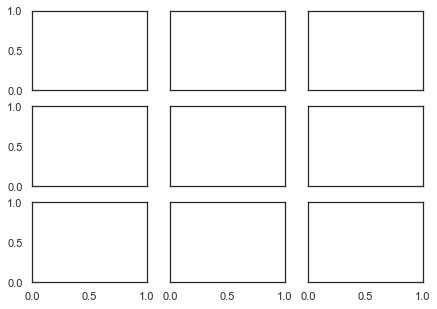

In [47]:
fig, axs = plt.subplots(3,3, figsize=(7,5), sharex=True, sharey=True)
i = 8
j = 0
xticks = [[0,75,150], [0,100,200],[0,100,200], [0,150,300]]
for (ef, ss, cc, av, pv, rs, sas, sts, pls), xtick in zip(scorelist, xticks):
    sns.set_style("white")
    scaler = MinMaxScaler()

    axs[0, 0].set_title("Execution Frequency", size=8, fontweight="bold", fontname="Times New Roman")
    axs[0, 0].plot(sorted(scaler.fit_transform(np.array([[e] for e  in ef])), reverse=True))
    axs[0 ,0].set_xticks(xtick)

    axs[0, 1].set_title("Resource Utilization", size=8, fontweight="bold", fontname="Times New Roman")
    axs[0, 1].plot(sorted(scaler.fit_transform(np.array([[e] for e  in ss])), reverse=True))

    axs[0, 2].set_title("Customer Contacts", size=8, fontweight="bold", fontname="Times New Roman")
    axs[0, 2].plot(sorted(scaler.fit_transform(np.array([[e] for e  in cc])), reverse=True))

    axs[1, 0].set_title("Activity Duration Variance", size=8, fontweight="bold", fontname="Times New Roman")
    axs[1, 0].plot(sorted(scaler.fit_transform(np.array([[e] for e  in av])), reverse=True))

    axs[1, 1].set_title("Execution Time Variance", size=8, fontweight="bold", fontname="Times New Roman")
    axs[1, 1].plot(sorted(scaler.fit_transform(np.array([[e] for e  in pv])), reverse=True))

    axs[1, 2].set_title("Execution Redundancies", size=8, fontweight="bold", fontname="Times New Roman")
    axs[1, 2].plot(sorted(scaler.fit_transform(np.array([[e] for e  in rs])), reverse=True))

    axs[2, 0].set_title("Shared Activity Contexts", size=8, fontweight="bold", fontname="Times New Roman")
    axs[2, 0].plot(sorted(scaler.fit_transform(np.array([[e] for e  in sas])), reverse=True))

    axs[2, 1].set_title("Stakeholder Involvement", size=8, fontweight="bold", fontname="Times New Roman")
    axs[2, 1].plot(sorted(scaler.fit_transform(np.array([[e] for e  in sts])), reverse=True))

    axs[2, 2].set_title("Process Length", size=8, fontweight="bold", fontname="Times New Roman")
    axs[2, 2].plot(sorted(scaler.fit_transform(np.array([[e] for e  in pls])), reverse=True))

    #fig.tight_layout()

    if (j == 0 )| (j == 2) | (j == 3):
        print("Figure_" + str(i) + ".svg")
        fig.savefig("Figure_" + str(i) + ".svg")
        #plt.show()
        fig.clf()
        fig, axs = plt.subplots(3,3, figsize=(7,5), sharex=True, sharey=True)
        i+=1
    
    j+= 1

### Plot Accumulated Scores

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,3), sharey=True)

sclistnorm = []

for score in scorelist:
    scorenorm = []
    for sc in score:
        scorenorm.append([x**2 for x in scaler.fit_transform(np.array([[e] for e  in sc]))])
    sclistnorm.append(scorenorm)
sns.reset_orig()


axs[0].plot((scaler.fit_transform(sorted(np.array(sclistnorm[0]).sum(axis=0), reverse=True))))
axs[1].plot((scaler.fit_transform(sorted(np.array(sclistnorm[1]).sum(axis=0), reverse=True))))
axs[1].plot((scaler.fit_transform(sorted(np.array(sclistnorm[2]).sum(axis=0), reverse=True))))
axs[2].plot((scaler.fit_transform(sorted(np.array(sclistnorm[3]).sum(axis=0), reverse=True))))
axs[0].set_title("IT Service Management Log", fontname="Times New Roman")
axs[1].set_title("Loan Application Log", fontname="Times New Roman")
axs[2].set_title("Building Permit Application Log", fontname="Times New Roman")
plt.tight_layout()
plt.savefig("Figure_11.svg")

### Save Data

In [ ]:
save_obj(scorelist[0], "loan2014.pkl")
save_obj(scorelist[1], "loan2012.pkl")
save_obj(scorelist[2], "bpi2017.pkl")
save_obj(scorelist[3], "bpi2015.pkl")

# Spider Plots

In [ ]:
scoredfs = []
for scores in scorelist:
    scorenorm = []
    for sc in scores:
        scorenorm.append([x**2 for x in scaler.fit_transform(np.array([[e] for e  in sc]))])

    d = {
        "EF":[a[0] for a in list(scaler.fit_transform(np.array([[e] for e  in scores[0]])))],
        "RU":[a[0] for a in list(scaler.fit_transform(np.array([[e] for e  in scores[1]])))],
        "CC":[a[0] for a in list(scaler.fit_transform(np.array([[e] for e  in scores[2]])))],
        "AD":[a[0] for a in list(scaler.fit_transform(np.array([[e] for e  in scores[3]])))],
        "ET":[a[0] for a in list(scaler.fit_transform(np.array([[e] for e  in scores[4]])))],
        "ER":[a[0] for a in list(scaler.fit_transform(np.array([[e] for e  in scores[5]])))],
        "SA":[a[0] for a in list(scaler.fit_transform(np.array([[e] for e  in scores[6]])))],
        "SI":[a[0] for a in list(scaler.fit_transform(np.array([[e] for e  in scores[7]])))],
        "PL":[a[0] for a in list(scaler.fit_transform(np.array([[e] for e  in scores[8]])))],
        "total": [a[0]  for a in list(np.array(scorenorm).sum(axis=0))]
    }
    scoredfs.append(pd.DataFrame(d).sort_values("total"))

scorenames= []

scorenames.append("Execution Frequency")
scorenames.append("Resource Utilization")
scorenames.append("Customer Contacts")
scorenames.append("Activity Duration Variance")
scorenames.append("Execution Time Variance")
scorenames.append("Execution Redundancies")
scorenames.append("Shared Activity Contexts")
scorenames.append("Stakeholder Involvement")
scorenames.append("Process Length")
scorenames.append("Execution Frequency")

titles = ["Loan Application Log 2012", "Loan Application Log 2017", "IT Service Management Log", "Building Permit Application Log"]

#breakpoints = [40, 40, 30, 150]

angles = [n / float(9) * 2 * pi for n in range(9)]
angles += angles[:1]
sns.set(style="whitegrid", rc={"lines.linewidth": 2})
sns.set_style("whitegrid")
#plt.style.use("ggplot")
f, axs = plt.subplots(2,2, subplot_kw=dict(projection='polar'), figsize=(12,12))

i = 0
j = 0
for d in [scoredfs[1], scoredfs[2], scoredfs[0], scoredfs[3]]:
    ratio = []
    #print(d.head())
    breakpoint = d.shape[0] // 5 * 4
    for t in range(9):
        c = d.values[:,t]
        ratio.append(sum([a for a in c[:breakpoint]]) / sum([a for a in c]))
    ratio.append(ratio[0])
    axs[i][j%2].set_theta_offset(pi / 2)
    axs[i][j%2].set_theta_direction(-1)
    axs[i][j%2].set_xticks(angles)
    axs[i][j%2].set_xticklabels(scorenames, fontweight="bold", fontname="Times New Roman", fontsize=10.5)
    axs[i][j%2].set_rlabel_position(0)
    axs[i][j%2].axes.set_ylim(0,1)
    axs[i][j%2].set_title(titles[j] + "\n", size=14, fontname="Times New Roman", fontweight="bold")
    axs[i][j%2].plot(angles, ratio, linewidth=1, linestyle='solid', color="blue")
    axs[i][j%2].fill(angles, ratio, 'b', color="blue", alpha=0.1)
    

    axs[i][j%2].plot(angles, [1-r for r in ratio], linewidth=1, linestyle='solid', color="red")
    axs[i][j%2].fill(angles, [1-r for r in ratio], 'b',color="red", alpha=0.1)
    

    j += 1

    if( j%2 == 0 ):
        i +=1

plt.tight_layout()
plt.savefig("Figure 12.svg")

# Plot Example Process Traces for Clusters

In [ ]:
df = dfs[0] # Chose BPI2014 as Example

In [ ]:
df.sort_values(["case:concept:name", "time:timestamp"])
df["time:next"] = df["time:timestamp"].tolist()[1:] + [pd.to_datetime("2000-01-01")]
df["case:next"] = df["case:concept:name"].tolist()[1:] + [0]
df["time"] =  (pd.to_datetime(df["time:next"], utc=True) - pd.to_datetime(df["time:timestamp"], utc=True)).apply(lambda x: x.total_seconds())

labels = fcluster(clusters, nclusters, criterion='maxclust')
traces["cluster"] = labels

clusterdict = {}
for i in range(1,nclusters+1):
    clusterdict[i] = traces.loc[traces["cluster"] == i]["case:concept:name"].tolist()

In [ ]:
varcount = traces.loc[traces["cluster"] == 10]
varcount.columns = ["asdf", "Activity", "CaseID"]
varcount = varcount[["Activity", "CaseID"]].to_dict()
variants = [(["Start"] + variant.split(",") + ["End"] , count) for variant, count in zip(varcount["Activity"].values(), varcount["CaseID"].values())]


plotGraphFromVariantsSimple(variants).draw('process10.png')

In [ ]:
varcount = traces.loc[traces["cluster"] == 12]
varcount.columns = ["asdf", "Activity", "CaseID"]
varcount = varcount[["Activity", "CaseID"]].to_dict()
variants = [(["Start"] + variant.split(",") + ["End"] , count) for variant, count in zip(varcount["Activity"].values(), varcount["CaseID"].values())]


plotGraphFromVariantsSimple(variants).draw('process12.png')